# Import libraries

In [42]:
import os
import cv2
from PIL import Image
from pathlib import Path
import Augmentor

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping


CNN - convolutional neural network - NN where the layers apply filters for specific features to areas within an image 

1) Convolutional Layer: In a typical neural network each input neuron is connected to the next hidden layer. In CNN, only a small region of the input layer neurons connect to the neuron hidden layer.

2) Pooling Layer: The pooling layer is used to reduce the dimensionality of the feature map. There will be multiple activation & pooling layers inside the hidden layer of the CNN.

3) Fully-Connected layer: Fully Connected Layers form the last few layers in the network. The input to the fully connected layer is the output from the final Pooling or Convolutional Layer, which is flattened and then fed into the fully connected layer.

STEPS
1) Import Libraries: Import the necessary libraries such as TensorFlow/Keras, OpenCV (cv2), and NumPy.

2) Load the Data: Read the images along with their corresponding labels. You can organize your dataset into folders where each folder represents a different class, and the images within each folder belong to that class.

3) Preprocess the Images:

Resize the images to a consistent size. CNNs typically require input images to be of the same size.
Normalize the pixel values to a range between 0 and 1.
Optionally, perform data augmentation to increase the diversity of your dataset. This can involve techniques like random rotation, flipping, shifting, etc.

4) Convert Images to Arrays: Convert the images to NumPy arrays. Each image will be represented as a 3D array (height x width x channels), where channels represent the color channels (e.g., RGB).

5) Split the Data: Split your dataset into training, validation, and test sets.

6) Build the CNN: Define the architecture of your CNN using a framework like TensorFlow/Keras. This typically involves stacking convolutional layers, pooling layers, and fully connected layers.

7) Compile the Model: Compile your CNN by specifying the loss function, optimizer, and evaluation metrics.

8) Train the Model: Train your CNN on the training data using the fit() method. Monitor the performance on the validation set to prevent overfitting.

9) Evaluate the Model: Evaluate the trained model on the test set to assess its performance.


# Load and preprocess images and labels

In [5]:
## make dictionary with diagnoses 
diagnoses = {
    0:'actinic keratosis',
    1:'basal cell carcinoma',
    2:'dermatofibroma',
    3:'melanoma',
    4:'nevus',
    5:'pigmented benign keratosis',
    6:'seborrheic keratosis',
    7:'squamous cell carcinoma',
    8:'vascular lesion'
}

In [6]:
train_dataset_path = r"C:\Users\irina\OneDrive\Documents\DeveloperAcademy\Final project\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
test_dataset_path = r"C:\Users\irina\OneDrive\Documents\DeveloperAcademy\Final project\Skin cancer ISIC The International Skin Imaging Collaboration\Test"

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dataset_path, validation_split=0.2, subset="training", seed=123, image_size=(224,224), batch_size=32)
# tf.data.dataset

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [8]:
class_names_train = train_ds.class_names
print(class_names_train)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [56]:
## Load and process data - define function
# note that CV2 reads images in BGR format 

def load_data(dataset_path, diagnoses):
    images = []
    labels = []

    for class_label, class_folder in diagnoses.items():
        class_path = os.path.join(dataset_path, class_folder)

        # Check if it's a directory
        if os.path.isdir(class_path):  
             
             # Iterate through images in class folder
             for img_file in os.listdir(class_path):
                    
                    img_path = os.path.join(class_path, img_file)
                    
                    # Check it's a file not a folder (to avoid output folder from last model)
                    if os.path.isfile(img_path):
                         
                         # Read and preprocess the image
                        img = cv2.imread(img_path)
                        img = cv2.resize(img, (224, 224))  # Resize to a common size

                        # Convert BGR image to RGB format
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                        img = img.astype('float32') / 255.0  # Normalize pixel values
                        ## each pixel has values from 0 to 255 for each of the RGB channels, dividing by 255 turns it into a value between 0 and 1, which is easier to work with 
                        
                        images.append(img_rgb)
                        labels.append(class_label)
        else:
            print(f"Folder '{class_folder}' not found in dataset path '{dataset_path}'.")

    return np.array(images), np.array(labels)

# EDA

- dataset is imbalanced - much fewer sebk, AK, and df
- total of only 2239 training images 

In [57]:
X_train, y_train = load_data(train_dataset_path, diagnoses)

# X_train contains the preprocessed train images, array
# y_train is the labels of the images, array 

In [62]:
X_test, y_test = load_data(test_dataset_path, diagnoses)

# X_test is the test images, array
# y_test is the labels to the images, array 

In [83]:
X_train.shape

## 2239 images, size 224x224, 3 channels for RGB

(2239, 224, 224, 3)

In [86]:
y_train.shape

## 2239 items, but just 1 integer for each which corresponds to the class 

(2239,)

## Count each class

In [63]:
# create variables for count and label values
dx_count = []
dx_labels = []

# iterate through the classes and get the count and label for each
for i in range(9):
    count = np.count_nonzero(y_train == i)
    dx_count.append(count)
    label = diagnoses.get(i)
    dx_labels.append(label)
    print(f"Within training set, count for class {i} : {label} is {count}")

Within training set, count for class 0 : actinic keratosis is 114
Within training set, count for class 1 : basal cell carcinoma is 376
Within training set, count for class 2 : dermatofibroma is 95
Within training set, count for class 3 : melanoma is 438
Within training set, count for class 4 : nevus is 357
Within training set, count for class 5 : pigmented benign keratosis is 462
Within training set, count for class 6 : seborrheic keratosis is 77
Within training set, count for class 7 : squamous cell carcinoma is 181
Within training set, count for class 8 : vascular lesion is 139


In [64]:
# recycled code to annotate bars in a barplot 
def annotate_bars(ax):
    ## annotate height of each bar in a bar plot 
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height()}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 5),
            textcoords='offset points'
        )

## Barchart in train ds

C:\Users\irina\AppData\Local\Temp\ipykernel_21928\574953177.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=dx_labels, y=dx_count, palette=colors)


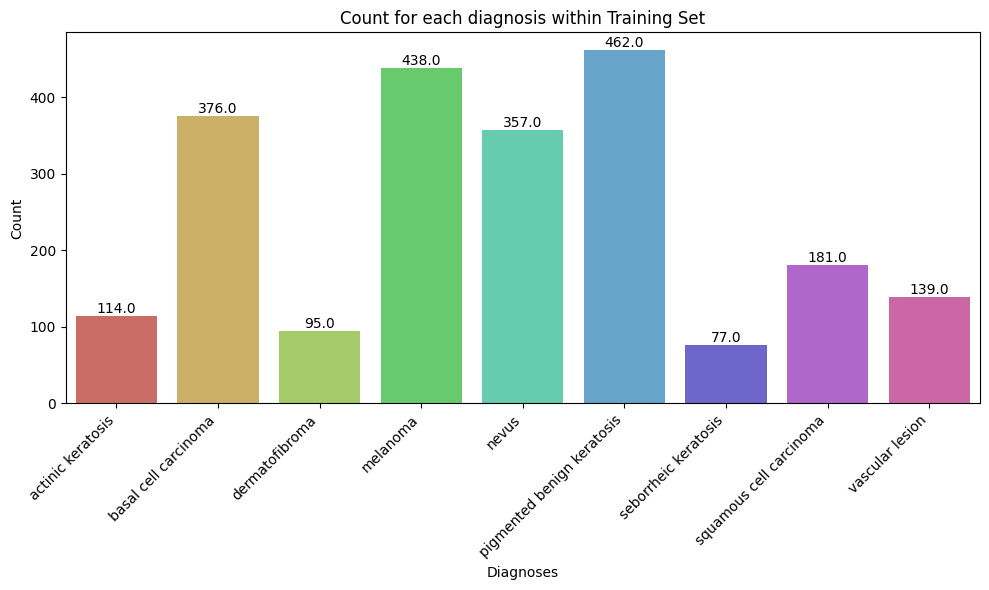

In [65]:
colors = sns.color_palette("hls", 9)

plt.figure(figsize=(10,6))
ax = sns.barplot(x=dx_labels, y=dx_count, palette=colors)
annotate_bars(ax)
plt.xlabel("Diagnoses")
plt.ylabel("Count")
plt.title("Count for each diagnosis within Training Set")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [66]:
count2 = []
labels2 = []

# iterate through the classes and get the count and label for each
for i in range(9):
    count = np.count_nonzero(y_test == i)
    count2.append(count)
    label = diagnoses.get(i)
    labels2.append(label)
    print(f"Within test set, count for class {i} : {label} is {count}")

Within test set, count for class 0 : actinic keratosis is 16
Within test set, count for class 1 : basal cell carcinoma is 16
Within test set, count for class 2 : dermatofibroma is 16
Within test set, count for class 3 : melanoma is 16
Within test set, count for class 4 : nevus is 16
Within test set, count for class 5 : pigmented benign keratosis is 16
Within test set, count for class 6 : seborrheic keratosis is 3
Within test set, count for class 7 : squamous cell carcinoma is 16
Within test set, count for class 8 : vascular lesion is 3


## Barchart in test ds

C:\Users\irina\AppData\Local\Temp\ipykernel_21928\1673385879.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels2, y=count2, palette=colors)


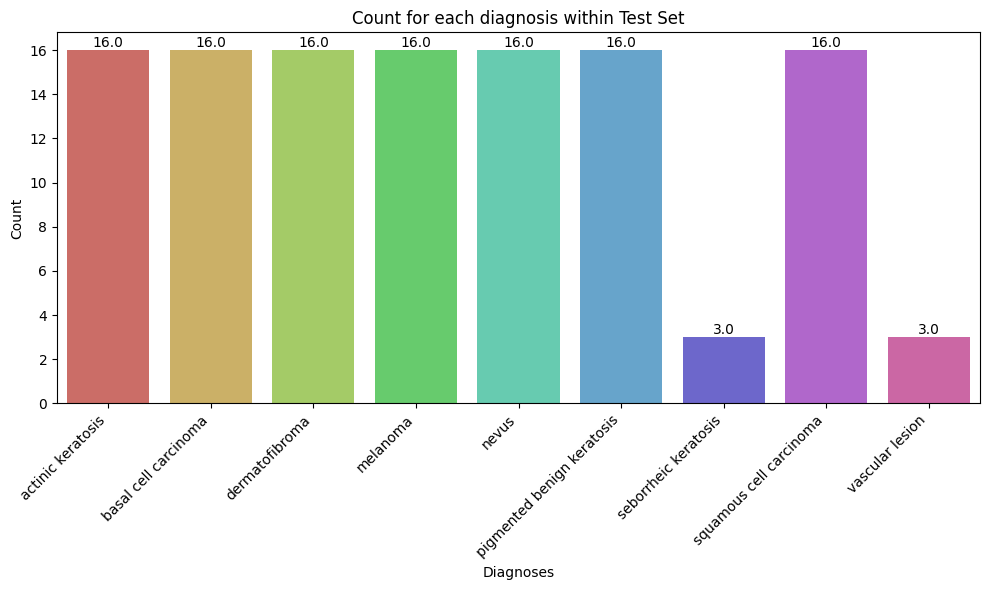

In [67]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=labels2, y=count2, palette=colors)
annotate_bars(ax)
plt.xlabel("Diagnoses")
plt.ylabel("Count")
plt.title("Count for each diagnosis within Test Set")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Show images of classes

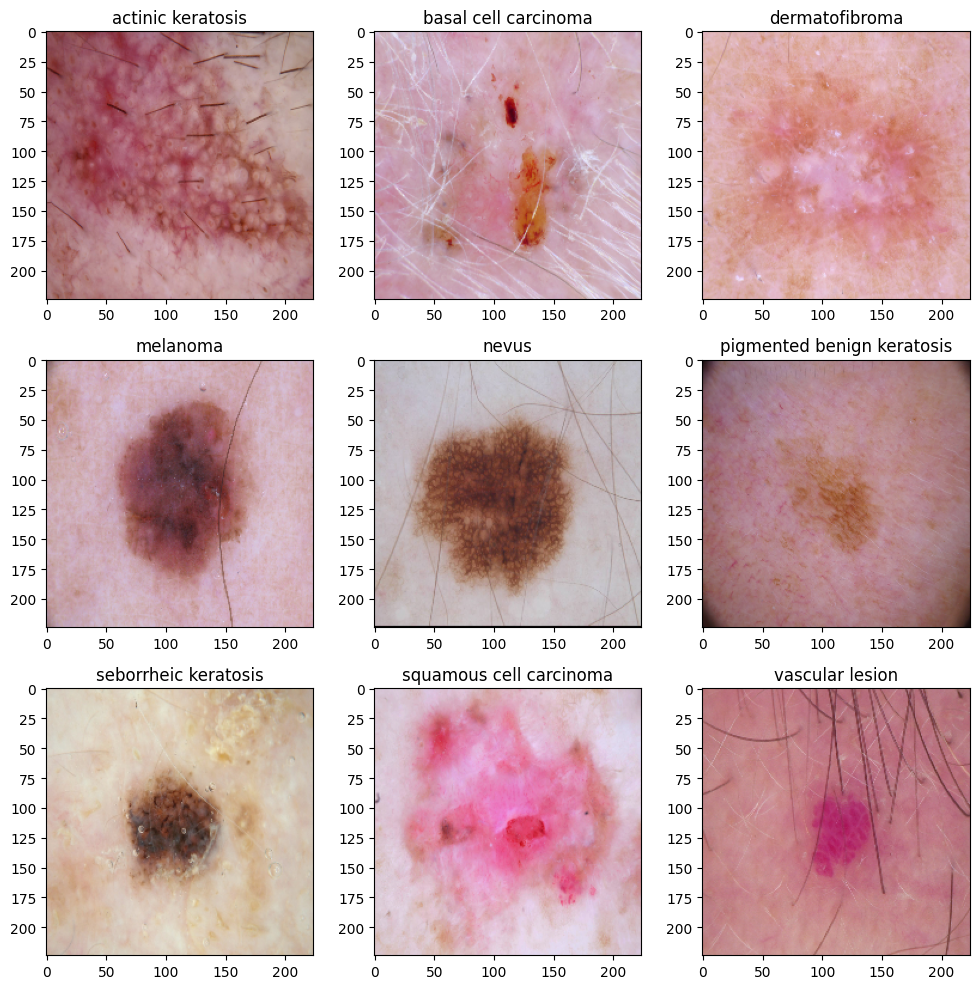

In [68]:
plt.figure(figsize=(10,10))

# Initialize a dictionary to store the index of the first occurrence of each class label
class_indices = {}

# Find the index of the first occurrence of each class label in the dataset
for i, label in enumerate(y_train):
    if label not in class_indices:
        class_indices[label] = i

# Iterate over each unique class label and display the corresponding image
for i, label in enumerate(class_indices.keys()):
    plt.subplot(3, 3, i+1)
    img_index = class_indices[label]
    plt.imshow(X_train[img_index])
    plt.title(dx_labels[label])

plt.tight_layout()
plt.show()

In [69]:
class_indices

{0: 0, 1: 114, 2: 490, 3: 585, 4: 1023, 5: 1380, 6: 1842, 7: 1919, 8: 2100}

# 1st CNN

In [70]:
# shuffle data

# Cache X_train
X_train_cached = X_train.copy()

# Shuffle the data
indices = np.arange(len(X_train_cached))
np.random.shuffle(indices)
X_train_cached = X_train_cached[indices]
y_train_cached = y_train[indices]


## Summary of first model
- images have been formatted to 224x224
- all pixels normalised by /255
- 13 layers
    - 10 convolutional layers - 5 Conv2D and 5 MaxPooling2D
    - 32, 64, 128, 256, 512
    - 1 flatten layer
    - 1 dense layer 1024, relu
    - output layer, softmax act
- sparse cat crossentropy

In [71]:
input_shape = (224, 224, 3) # size 224x224 with 3 RGB channels 
num_dx = len(diagnoses)

cnn = models.Sequential([
    
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten layer
    layers.Flatten(),
    
    # Dense (fully connected) layers
    layers.Dense(1024, activation='relu'),
    layers.Dense(num_dx, activation='softmax')  # Output layer
])


In [72]:
# Compile the model
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 26, 26, 128)      

In [73]:
epochs = 30

In [88]:
# Train model on our data
history = cnn.fit(X_train_cached, y_train_cached, epochs=epochs, batch_size=32, validation_data=(X_test,y_test))


Epoch 1/30
 3/70 [>.............................] - ETA: 1:06 - loss: 177.7268 - accuracy: 0.1562

KeyboardInterrupt: 

In [34]:
range_epochs = range(epochs)

training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

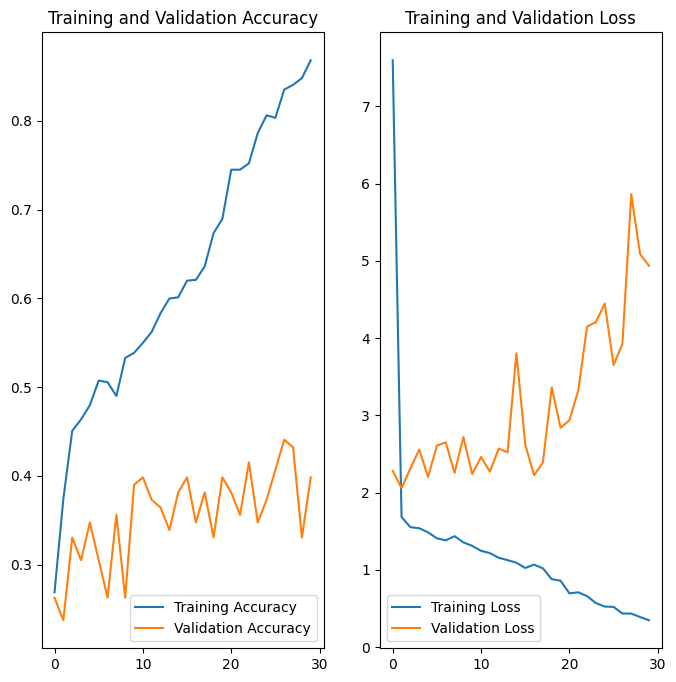

In [35]:
# Plot the training and val accuracies for the epochs
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range_epochs, training_accuracy, label='Training Accuracy')
plt.plot(range_epochs, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range_epochs, training_loss, label='Training Loss')
plt.plot(range_epochs, validation_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
y_pred_prob = cnn.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

4/4 [==============================] - 1s 185ms/step


Accuracy: 0.3983050847457627


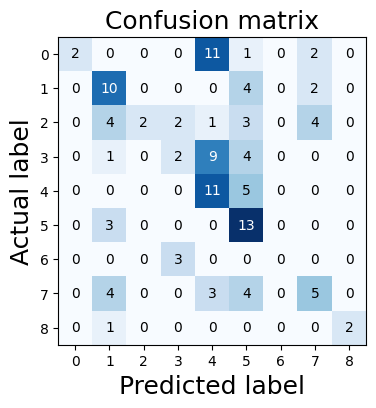

In [37]:
## calculate accuracy and confusion matrix
accuracy_cnn = accuracy_score(y_test, y_pred)
conf_mat_cnn =  confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy_cnn}")

fig, ax2 = plot_confusion_matrix(conf_mat=conf_mat_cnn, figsize=(4,4))
plt.xlabel('Predicted label', fontsize = 18)
plt.ylabel('Actual label', fontsize = 18)
plt.title('Confusion matrix', fontsize = 18)
plt.show()

# Dense Net 

In [89]:
# Load the DenseNet model
dense121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification head
x = dense121_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling layer
x = Dense(1024, activation='relu')(x)  # Add fully connected layer
x = Dropout(0.5)(x)  # Add dropout layer for regularization
predictions = Dense(num_dx, activation='softmax')(x)  # Add output layer with softmax activation

# Create model
model_121 = Model(inputs=dense121_model.input, outputs=predictions)

In [91]:
# Convert integer labels to one-hot encoded format
y_train_cached_onehot = tf.keras.utils.to_categorical(y_train_cached, num_classes=9)

In [94]:
# Compile the model
model_121.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [100]:
# Train the model
history_121 = model_121.fit(X_train_cached, y_train_cached_onehot, epochs=25, validation_split=0.2)

Epoch 1/25
56/56 [==============================] - 362s 6s/step - loss: 0.4544 - accuracy: 0.8314 - val_loss: 2.6338 - val_accuracy: 0.4464
Epoch 2/25
56/56 [==============================] - 356s 6s/step - loss: 0.4183 - accuracy: 0.8381 - val_loss: 2.5791 - val_accuracy: 0.4464
Epoch 3/25
56/56 [==============================] - 352s 6s/step - loss: 0.4679 - accuracy: 0.8185 - val_loss: 1.5002 - val_accuracy: 0.6049
Epoch 4/25
56/56 [==============================] - 347s 6s/step - loss: 0.5086 - accuracy: 0.8135 - val_loss: 2.7400 - val_accuracy: 0.4665
Epoch 5/25
56/56 [==============================] - 350s 6s/step - loss: 0.3876 - accuracy: 0.8470 - val_loss: 4.3864 - val_accuracy: 0.3817
Epoch 6/25
56/56 [==============================] - 354s 6s/step - loss: 0.4141 - accuracy: 0.8370 - val_loss: 5.6408 - val_accuracy: 0.3281
Epoch 7/25
56/56 [==============================] - 351s 6s/step - loss: 0.3595 - accuracy: 0.8543 - val_loss: 1.7306 - val_accuracy: 0.5558
Epoch 8/25
56

In [101]:
range_epochs = range(25)

training_loss_121 = history_121.history['loss']
training_accuracy_121 = history_121.history['accuracy']
validation_loss_121 = history_121.history['val_loss']
validation_accuracy_121 = history_121.history['val_accuracy']

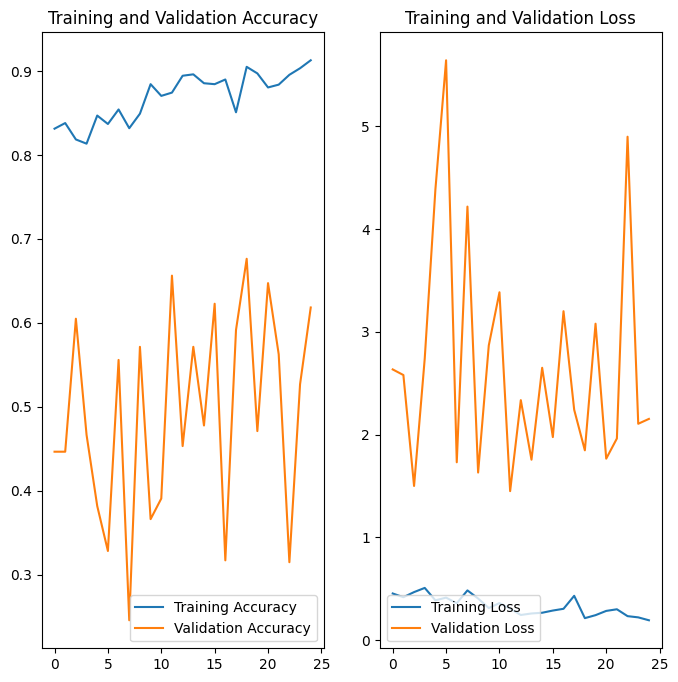

In [102]:
# Plot the training and val accuracies for the epochs
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range_epochs, training_accuracy_121, label='Training Accuracy')
plt.plot(range_epochs, validation_accuracy_121, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range_epochs, training_loss_121, label='Training Loss')
plt.plot(range_epochs, validation_loss_121, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

In [103]:
y_pred_prob_121 = model_121.predict(X_test)
y_pred_121 = np.argmax(y_pred_prob_121, axis=1)

4/4 [==============================] - 6s 1s/step


Accuracy: 0.4661016949152542


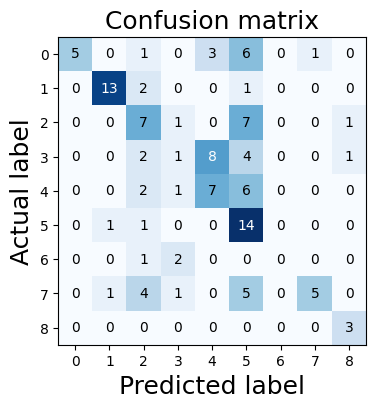

In [104]:
## calculate accuracy and confusion matrix
accuracy_cnn_121 = accuracy_score(y_test, y_pred_121)
conf_mat_cnn_121 =  confusion_matrix(y_test, y_pred_121)

print(f"Accuracy: {accuracy_cnn_121}")

fig, ax2 = plot_confusion_matrix(conf_mat=conf_mat_cnn_121, figsize=(4,4))
plt.xlabel('Predicted label', fontsize = 18)
plt.ylabel('Actual label', fontsize = 18)
plt.title('Confusion matrix', fontsize = 18)
plt.show()

# Data Augmentation

In [39]:
# add aug layer 
# add dropout layers 

cnn_aug = models.Sequential([
    # Augmentation layers 
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),

    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.15),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.20),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten layer
    layers.Flatten(),
    
    # Dense (fully connected) layers
    layers.Dense(1024, activation='relu'),
    layers.Dense(num_dx, activation='softmax')  # Output layer
])

In [40]:
# Compile the model
cnn_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
cnn_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)     

In [41]:
# Train model on our data
history_aug = cnn_aug.fit(X_train_cached, y_train_cached, epochs=epochs, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/30
70/70 [==============================] - 69s 964ms/step - loss: 11.6322 - accuracy: 0.2564 - val_loss: 2.1430 - val_accuracy: 0.2034
Epoch 2/30
70/70 [==============================] - 66s 948ms/step - loss: 1.6723 - accuracy: 0.4118 - val_loss: 2.3250 - val_accuracy: 0.2712
Epoch 3/30
70/70 [==============================] - 66s 946ms/step - loss: 1.7129 - accuracy: 0.3899 - val_loss: 2.3539 - val_accuracy: 0.2966
Epoch 4/30
70/70 [==============================] - 66s 947ms/step - loss: 1.6282 - accuracy: 0.4185 - val_loss: 2.2052 - val_accuracy: 0.2966
Epoch 5/30
70/70 [==============================] - 67s 952ms/step - loss: 1.6041 - accuracy: 0.4408 - val_loss: 2.0359 - val_accuracy: 0.3390
Epoch 6/30
70/70 [==============================] - 67s 952ms/step - loss: 1.7177 - accuracy: 0.3984 - val_loss: 2.2940 - val_accuracy: 0.3136
Epoch 7/30
70/70 [==============================] - 66s 948ms/step - loss: 1.5230 - accuracy: 0.4533 - val_loss: 2.1391 - val_accuracy: 0.254

In [42]:
range_epochs = range(epochs)

training_loss_aug = history_aug.history['loss']
training_accuracy_aug = history_aug.history['accuracy']
validation_loss_aug = history_aug.history['val_loss']
validation_accuracy_aug = history_aug.history['val_accuracy']

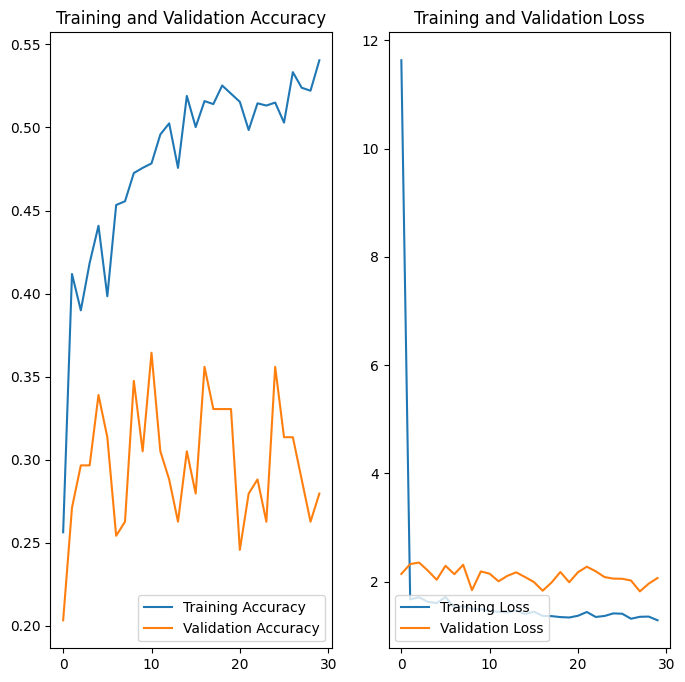

In [43]:
# Plot the training and val accuracies for the epochs
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range_epochs, training_accuracy_aug, label='Training Accuracy')
plt.plot(range_epochs, validation_accuracy_aug, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range_epochs, training_loss_aug, label='Training Loss')
plt.plot(range_epochs, validation_loss_aug, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
y_pred_prob_aug = cnn_aug.predict(X_test)
y_pred_aug = np.argmax(y_pred_prob_aug, axis=1)

4/4 [==============================] - 1s 179ms/step


Accuracy: 0.2796610169491525


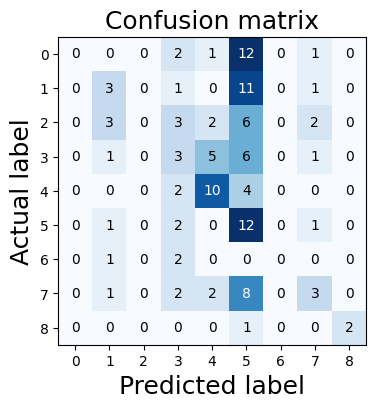

In [45]:
## calculate accuracy and confusion matrix
accuracy_cnn_aug = accuracy_score(y_test, y_pred_aug)
conf_mat_cnn_aug =  confusion_matrix(y_test, y_pred_aug)

print(f"Accuracy: {accuracy_cnn_aug}")

fig, ax2 = plot_confusion_matrix(conf_mat=conf_mat_cnn_aug, figsize=(4,4))
plt.xlabel('Predicted label', fontsize = 18)
plt.ylabel('Actual label', fontsize = 18)
plt.title('Confusion matrix', fontsize = 18)
plt.show()

# Augmentor

In [9]:
## make new dict
inv_diagnoses = {
    'actinic keratosis':0,
    'basal cell carcinoma':1,
    'dermatofibroma':2,
    'melanoma':3,
    'nevus':4,
    'pigmented benign keratosis':5,
    'seborrheic keratosis':6,
    'squamous cell carcinoma':7,
    'vascular lesion':8
}

In [11]:
# Assuming dx_labels contains the same labels as the subfolder names in train_dataset_path
# Iterate over the subfolders in train_dataset_path
for subfolder in os.listdir(train_dataset_path):
    subfolder_path = os.path.join(train_dataset_path, subfolder)
    if os.path.isdir(subfolder_path):
        # Now subfolder contains the name of the subfolder, which corresponds to a diagnosis label
        p = Augmentor.Pipeline(subfolder_path)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(1000)



Initialised with 114 image(s) found.
Output directory set to C:\Users\irina\OneDrive\Documents\DeveloperAcademy\Final project\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F24B83FAD0>: 100%|██████████| 1000/1000 [00:06<00:00, 166.31 Samples/s]                 


Initialised with 376 image(s) found.
Output directory set to C:\Users\irina\OneDrive\Documents\DeveloperAcademy\Final project\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1F20E8748D0>: 100%|██████████| 1000/1000 [00:05<00:00, 180.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to C:\Users\irina\OneDrive\Documents\DeveloperAcademy\Final project\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1F20E7FEB10>: 100%|██████████| 1000/1000 [00:04<00:00, 209.91 Samples/s]


Initialised with 438 image(s) found.
Output directory set to C:\Users\irina\OneDrive\Documents\DeveloperAcademy\Final project\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1F20E816890>: 100%|██████████| 1000/1000 [00:25<00:00, 39.13 Samples/s]


Initialised with 357 image(s) found.
Output directory set to C:\Users\irina\OneDrive\Documents\DeveloperAcademy\Final project\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=796x682 at 0x1F2079E8810>: 100%|██████████| 1000/1000 [00:23<00:00, 43.31 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to C:\Users\irina\OneDrive\Documents\DeveloperAcademy\Final project\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F2079B5650>: 100%|██████████| 1000/1000 [00:05<00:00, 195.13 Samples/s]                 


Initialised with 77 image(s) found.
Output directory set to C:\Users\irina\OneDrive\Documents\DeveloperAcademy\Final project\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1F2078B0B90>: 100%|██████████| 1000/1000 [00:10<00:00, 98.20 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\irina\OneDrive\Documents\DeveloperAcademy\Final project\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F20E557D10>: 100%|██████████| 1000/1000 [00:05<00:00, 170.52 Samples/s]                 


Initialised with 139 image(s) found.
Output directory set to C:\Users\irina\OneDrive\Documents\DeveloperAcademy\Final project\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F20E6D20D0>: 100%|██████████| 1000/1000 [00:05<00:00, 173.38 Samples/s]                 


In [12]:
# Create a list of diagnosis subfolders
diagnosis_subfolders = [folder 
                        for folder in os.listdir(train_dataset_path) 
                            if os.path.isdir(os.path.join(train_dataset_path, folder))]



In [14]:
augmentor_images = []
augmentor_labels = []

# Iterate through each diagnosis subfolder
for subfolder in diagnosis_subfolders:
    subfolder_path = os.path.join(train_dataset_path, subfolder)
    output_subfolder_path = os.path.join(subfolder_path, "output")

    # Check if the output subfolder exists
    if os.path.exists(output_subfolder_path):
        # Count the number of image files in the output subfolder
        num_images = len([filename for filename in os.listdir(output_subfolder_path) if filename.endswith(('.jpg'))])
        print(f"Diagnosis: {subfolder}, Number of images: {num_images}")

        # Get the numerical label for the diagnosis
        label = inv_diagnoses[subfolder]

        for img_file in os.listdir(output_subfolder_path):
                img_path = os.path.join(output_subfolder_path, img_file)
                
                # Read and preprocess the image
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))  # Resize to a common size

                # Convert BGR image to RGB format
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img_rgb = img.astype('float32') / 255.0  # Normalize pixel values
                ## each pixel has values from 0 to 255 for each of the RGB channels, dividing by 255 turns it into a value between 0 and 1, which is easier to work with 
                
                augmentor_images.append(img_rgb)
                augmentor_labels.append(label)
    else:
        print(f"No output folder found for diagnosis: {subfolder}")

Diagnosis: actinic keratosis, Number of images: 1000
Diagnosis: basal cell carcinoma, Number of images: 1000
Diagnosis: dermatofibroma, Number of images: 1000
Diagnosis: melanoma, Number of images: 1000
Diagnosis: nevus, Number of images: 1000
Diagnosis: pigmented benign keratosis, Number of images: 1000
Diagnosis: seborrheic keratosis, Number of images: 1000
Diagnosis: squamous cell carcinoma, Number of images: 1000
Diagnosis: vascular lesion, Number of images: 1000


In [21]:
X = np.array(augmentor_images)
y = np.array(augmentor_labels)

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, you can print the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7200, 224, 224, 3)
X_test shape: (1800, 224, 224, 3)
y_train shape: (7200,)
y_test shape: (1800,)


In [24]:
y_train.dtype

dtype('int32')

In [27]:
cnn_augmentor = models.Sequential([
    
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.15),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.20),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten layer
    layers.Flatten(),
    
    # Dense (fully connected) layers
    layers.Dense(1024, activation='relu'),
    layers.Dense(num_dx, activation='softmax')  # Output layer
])

In [28]:
# Compile the model
cnn_augmentor.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
cnn_augmentor.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 128)     

In [29]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights=True)

epochs = 50

In [31]:
history_augmentor = cnn_augmentor.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks = [early_stopping])

Epoch 1/50


225/225 [==============================] - 274s 1s/step - loss: 1.8283 - accuracy: 0.2672 - val_loss: 1.6220 - val_accuracy: 0.3456
Epoch 2/50
225/225 [==============================] - 236s 1s/step - loss: 1.5525 - accuracy: 0.3849 - val_loss: 1.4172 - val_accuracy: 0.4628
Epoch 3/50
225/225 [==============================] - 216s 959ms/step - loss: 1.3829 - accuracy: 0.4556 - val_loss: 1.3110 - val_accuracy: 0.4839
Epoch 4/50
225/225 [==============================] - 220s 978ms/step - loss: 1.2461 - accuracy: 0.5224 - val_loss: 1.2652 - val_accuracy: 0.5261
Epoch 5/50
225/225 [==============================] - 217s 964ms/step - loss: 1.0775 - accuracy: 0.5854 - val_loss: 1.0247 - val_accuracy: 0.6100
Epoch 6/50
225/225 [==============================] - 251s 1s/step - loss: 0.9262 - accuracy: 0.6540 - val_loss: 0.9575 - val_accuracy: 0.6617
Epoch 7/50
225/225 [==============================] - 255s 1s/step - loss: 0.7705 - accuracy: 0.7156 - val_loss: 0.7789 - val_accur

In [34]:
early_stopping.stopped_epoch

24

In [37]:
range_epochs = range(early_stopping.stopped_epoch+1)

training_loss_augmentor = history_augmentor.history['loss']
training_accuracy_augmentor = history_augmentor.history['accuracy']
validation_loss_augmentor = history_augmentor.history['val_loss']
validation_accuracy_augmentor = history_augmentor.history['val_accuracy']

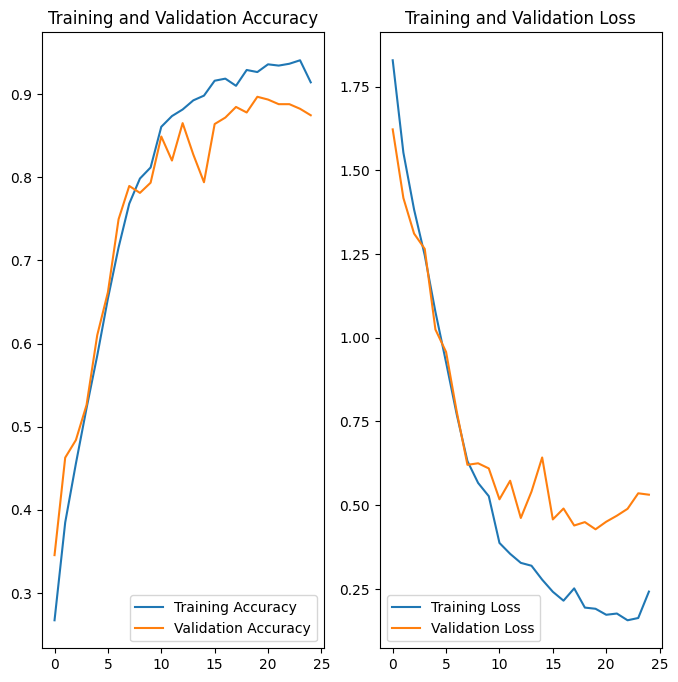

In [38]:
# Plot the training and val accuracies for the epochs
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range_epochs, training_accuracy_augmentor, label='Training Accuracy')
plt.plot(range_epochs, validation_accuracy_augmentor, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range_epochs, training_loss_augmentor, label='Training Loss')
plt.plot(range_epochs, validation_loss_augmentor, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
y_pred_prob_augmentor = cnn_augmentor.predict(X_test)
y_pred_augmentor = np.argmax(y_pred_prob_augmentor, axis=1)

57/57 [==============================] - 16s 269ms/step


Accuracy: 0.8966666666666666


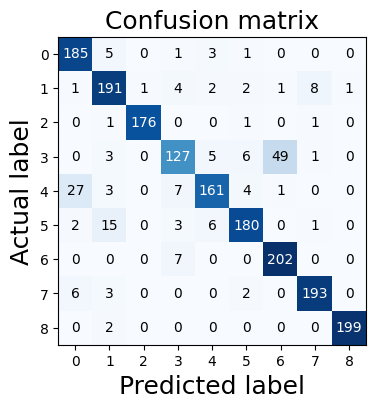

In [40]:
## calculate accuracy and confusion matrix
accuracy_cnn_augmentor = accuracy_score(y_test, y_pred_augmentor)
conf_mat_cnn_augmentor =  confusion_matrix(y_test, y_pred_augmentor)

print(f"Accuracy: {accuracy_cnn_augmentor}")

fig, ax3 = plot_confusion_matrix(conf_mat=conf_mat_cnn_augmentor, figsize=(4,4))
plt.xlabel('Predicted label', fontsize = 18)
plt.ylabel('Actual label', fontsize = 18)
plt.title('Confusion matrix', fontsize = 18)
plt.show()